# SPAN Benchmarks H3K4me3 vs RNA-seq

See https://pubmed.ncbi.nlm.nih.gov/27169896/


In [80]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os

In [81]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

# Hg38 load peaks

In [82]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K4me3']
GSE26320_REPS = ['rep1', 'rep2']

In [83]:

def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = 'rep1' if 'rep1' in f else 'rep2'
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (f, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [84]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['file'] = [f'{GSE26320_PATH_HG38}/macs2/{f}' for f in df_fdr_macs2['file']]
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['file'] = [f'{GSE26320_PATH_HG38}/macs2/{f}' for f in df_fdr_macs2broad['file']]
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
df_fdr_sicer['file'] = [f'{GSE26320_PATH_HG38}/sicer/{f}' for f in df_fdr_sicer['file']]
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['file'] = [f'{GSE26320_PATH_HG38}/span/{f}' for f in df_fdr_span['file']]
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/264 [00:00<?, ?it/s]

MACS2 16


  0%|          | 0/264 [00:00<?, ?it/s]

MACS2 broad 16


  0%|          | 0/33 [00:00<?, ?it/s]

SICER 16


  0%|          | 0/36 [00:00<?, ?it/s]

SPAN 16


,file,modification,cell,replicate,fdr,peaks,avlength,tool
4,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,GM12878,rep2,0.1,27319,2109.398587,MACS2 broad
8,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,NHLF,rep2,0.1,23095,1751.767699,MACS2 broad
3,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,Huvec,rep2,0.1,16664,1483.145223,MACS2 broad
6,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,HepG2,rep2,0.01,30452,2639.253514,SICER
15,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K4me3,K562,rep1,0.05,31515,2189.203649,SPAN


In [86]:
# TOOLS_PALETTE = {'MACS2': 'blue', 'MACS2 broad': 'orange', 'SICER': 'green', 'SPAN': 'red', 'Genes': 'brown'}
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

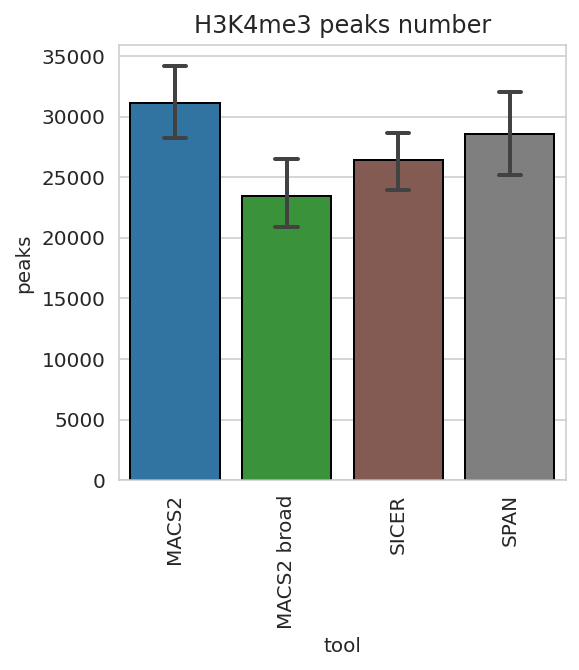

In [87]:
# plt.figure(figsize=(4, 4))
# ax = plt.axes()
# g_results = sns.boxplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
#                         palette=TOOLS_PALETTE)
# ax.xaxis.set_tick_params(rotation=90)
# ax.title.set_text('H3K4me3 peaks number')
# plt.show()

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me3 peaks number')
plt.show()

In [8]:
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,tool,length
70319,MACS2,423
500115,SPAN,2649
251026,MACS2 broad,3785
405804,SICER,1399
484375,SPAN,1171
326687,SICER,799
514020,SPAN,767
440893,SICER,2599
14596,MACS2,341
313843,MACS2 broad,1006


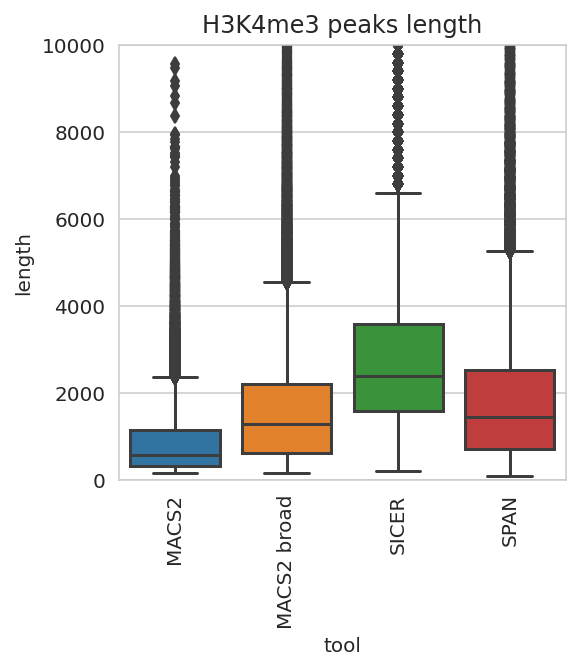

In [9]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax)
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 10_000])
plt.show()

ValueError: Could not interpret value `length` for parameter `x`

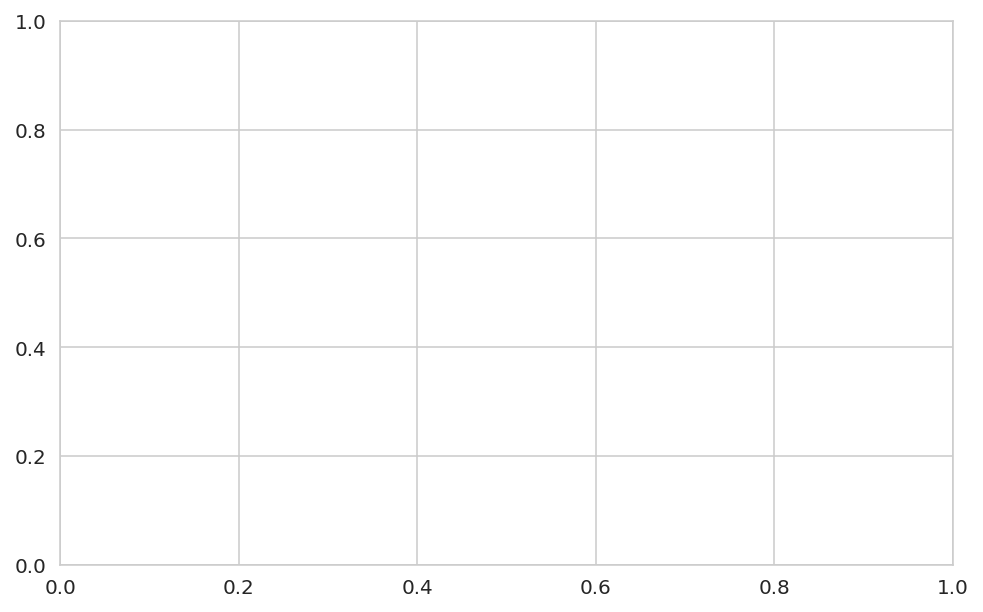

In [79]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

In [11]:
# Randomly tweak SPAN,SICER lengths for visualization purposes
tspan = t['tool'] == 'SPAN'
t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))
tsicer = t['tool'] == 'SICER'
t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


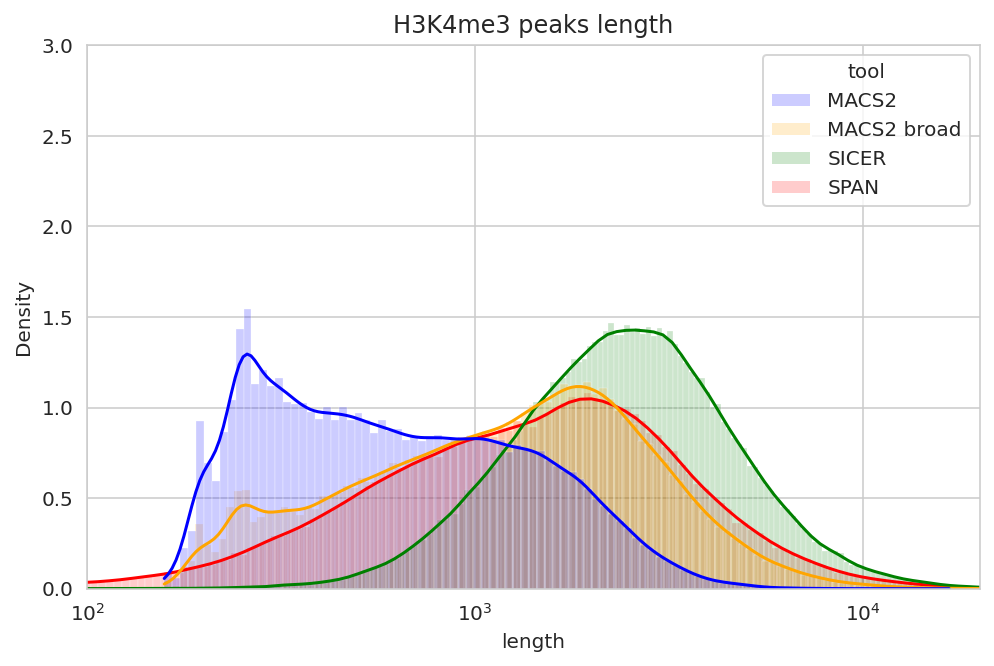

In [12]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

## Consistency analysis between replicates

In [13]:
from itertools import product

reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks2', 'overlap', 'peaks1_overlap', 'peaks2_overlap'], dtype=object)

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                file1 = t1['file'].values[0]
                file2 = t2['file'].values[0]
                peaks1 = t1['peaks'].values[0]
                peaks2 = t2['peaks'].values[0]
                length1 = bedl(file1).sum()
                length2 = bedl(file2).sum()

                for overlap, overlap_param in [
                    ('1bp overlap', ''),
                    ('50% overlap', ' -f 0.5 ')
                ]:
                    overlap1 = !bedtools intersect -a {file1} -b {file2} -wa -u {overlap_param} | wc -l
                    overlap1 = int(overlap1[0])
                    overlap2 = !bedtools intersect -b {file1} -a {file2} -wa -u {overlap_param} | wc -l
                    overlap2 = int(overlap2[0])

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks2, overlap, overlap1, overlap2)

reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]
reps_overlap

0it [00:00, ?it/s]

GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3


,modification,cell,tool,rep1,rep2,peaks1,peaks2,overlap,peaks1_overlap,peaks2_overlap,peak1_overlap_fraction,peak2_overlap_fraction
0,H3K4me3,GM12878,MACS2,rep1,rep2,41149,38141,1bp overlap,30841,26627,0.749496,0.698120
1,H3K4me3,GM12878,MACS2,rep1,rep2,41149,38141,50% overlap,26547,19278,0.645143,0.505440
2,H3K4me3,GM12878,MACS2 broad,rep1,rep2,29024,27319,1bp overlap,22221,22039,0.765608,0.806728
3,H3K4me3,GM12878,MACS2 broad,rep1,rep2,29024,27319,50% overlap,19335,19070,0.666173,0.698049
4,H3K4me3,GM12878,SICER,rep1,rep2,32672,31862,1bp overlap,27067,27170,0.828446,0.852740
5,H3K4me3,GM12878,SICER,rep1,rep2,32672,31862,50% overlap,23934,25105,0.732554,0.787929
6,H3K4me3,GM12878,SPAN,rep1,rep2,35518,32854,1bp overlap,27825,27943,0.783406,0.850520
7,H3K4me3,GM12878,SPAN,rep1,rep2,35518,32854,50% overlap,23970,25204,0.674869,0.767152
8,H3K4me3,HMEC,MACS2,rep1,rep2,26661,24894,1bp overlap,19303,20868,0.724016,0.838274
9,H3K4me3,HMEC,MACS2,rep1,rep2,26661,24894,50% overlap,15166,18114,0.568846,0.727645


In [14]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'overlap']
    ].copy().rename(dict(peak1_overlap_fraction='value'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'overlap']
    ].copy().rename(dict(peak2_overlap_fraction='value'), axis=1)
]).reset_index(drop=True)
t

,modification,cell,tool,value,overlap
0,H3K4me3,GM12878,MACS2,0.749496,1bp overlap
1,H3K4me3,GM12878,MACS2,0.645143,50% overlap
2,H3K4me3,GM12878,MACS2 broad,0.765608,1bp overlap
3,H3K4me3,GM12878,MACS2 broad,0.666173,50% overlap
4,H3K4me3,GM12878,SICER,0.828446,1bp overlap
...,...,...,...,...,...
107,H3K4me3,Huvec,MACS2 broad,0.888682,50% overlap
108,H3K4me3,Huvec,SICER,0.852093,1bp overlap
109,H3K4me3,Huvec,SICER,0.817216,50% overlap
110,H3K4me3,Huvec,SPAN,0.762806,1bp overlap


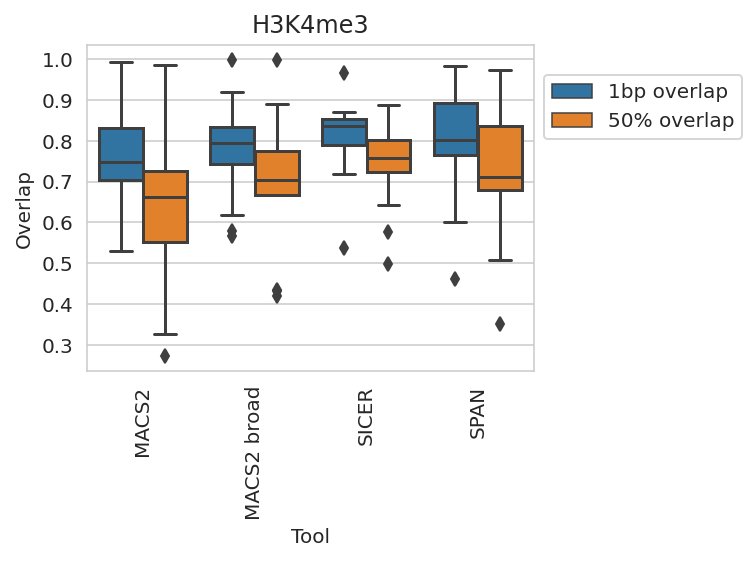

In [15]:
plt.figure(figsize=(len(GSE26320_MODIFICATIONS) * 4, 3))
for k, m in enumerate(GSE26320_MODIFICATIONS):
    ax = plt.subplot(1, len(GSE26320_MODIFICATIONS), k + 1)
    sns.boxplot(data=t[t['modification'] == m], x='tool', y='value', hue='overlap', ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(m)
    ax.set_xlabel('Tool')
    if k == 0:
        ax.set_ylabel('Overlap')
    else:
        ax.set_ylabel(None)
    if k == len(GSE26320_MODIFICATIONS) - 1:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.81))
    else:
        ax.get_legend().remove()
# plt.savefig(f'{GSE26320_PATH_HG38}/analyze/overlap.pdf', bbox_inches='tight', dpi=300)
plt.show()

# H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps the promoter of an expressed gene (RPKM > 0.5).
The top 15 000 peak calls from the different methods are ranked by their significance or by their fold enrichment for the thresholding method. We plotted the correct peak fraction (fraction of the top 1000xn peaks that overlap with active promoters) detected as a function of the correct promoter fraction (fraction of the active promoters that overlap with the top 1000xn peaks).

## Load hg38 gtf

In [16]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

,chromosome,db,type,start,end,point1,strand,point2,aux
2014635,chr12,HAVANA,start_codon,14423916,14423918,.,+,0,"gene_id ""ENSG00000171681.13""; transcript_id ""E..."
1932663,chr11,HAVANA,CDS,88334937,88335082,.,-,2,"gene_id ""ENSG00000109861.17""; transcript_id ""E..."
72884,chr1,HAVANA,CDS,36418991,36419054,.,-,1,"gene_id ""ENSG00000116885.18""; transcript_id ""E..."
1779197,chr10,HAVANA,exon,130160796,130160997,.,+,.,"gene_id ""ENSG00000108010.12""; transcript_id ""E..."
1357490,chr7,HAVANA,UTR,114426502,114426511,.,+,.,"gene_id ""ENSG00000128573.27""; transcript_id ""E..."
2062973,chr12,HAVANA,exon,53170423,53170502,.,-,.,"gene_id ""ENSG00000139631.20""; transcript_id ""E..."
1194054,chr6,HAVANA,start_codon,110958770,110958772,.,+,0,"gene_id ""ENSG00000155115.7""; transcript_id ""EN..."
2584743,chr16,HAVANA,exon,69448115,69448144,.,+,.,"gene_id ""ENSG00000103018.18""; transcript_id ""E..."
1679863,chr10,HAVANA,exon,32985623,32985762,.,+,.,"gene_id ""ENSG00000229656.9""; transcript_id ""EN..."
2586079,chr16,HAVANA,CDS,70148464,70148553,.,+,0,"gene_id ""ENSG00000090857.14""; transcript_id ""E..."


In [17]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [18]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


,chromosome,db,type,start,end,point1,strand,point2,gene_id,gene_type,gene_name,level
1637841,chr9,ENSEMBL,gene,134379411,134379472,.,+,.,ENSG00000263897,miRNA,MIR4669,3
422710,chr2,HAVANA,gene,100425348,100426107,.,+,.,ENSG00000238029,processed_pseudogene,RALBP1P2,1
440749,chr2,HAVANA,gene,123695302,123697396,.,+,.,ENSG00000235640,processed_pseudogene,ELOAP1,1
2545645,chr16,HAVANA,gene,35090501,35104834,.,+,.,ENSG00000260809,unprocessed_pseudogene,VPS35P1,2
1021921,chr5,ENSEMBL,gene,134701172,134701278,.,-,.,ENSG00000201298,snRNA,RNU6-1164P,3


## Annotate quanitified RNA-seq with TSS positions

  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv


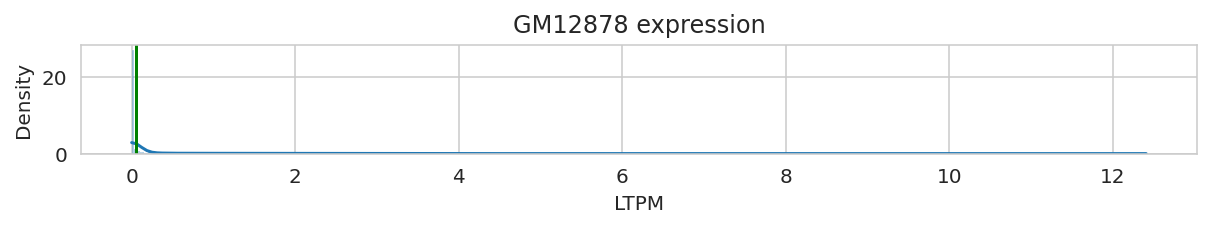

Total genes with positions 58387
Genes logTPM > 0.05 17538
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.05_tss2000.bed
GM12878 rep2 GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv


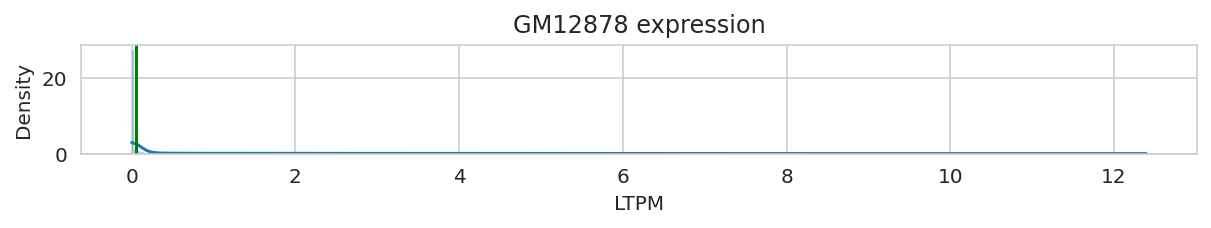

Total genes with positions 56646
Genes logTPM > 0.05 17392
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.05_tss2000.bed
H1 rep1 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv


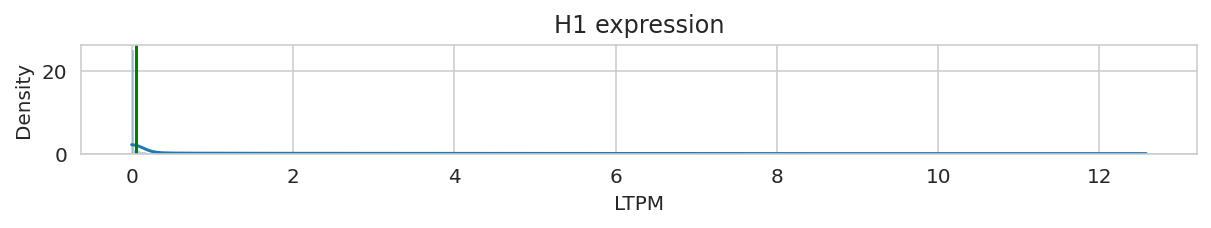

Total genes with positions 56646
Genes logTPM > 0.05 20899
Saved expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.05_tss2000.bed
H1 rep2 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv


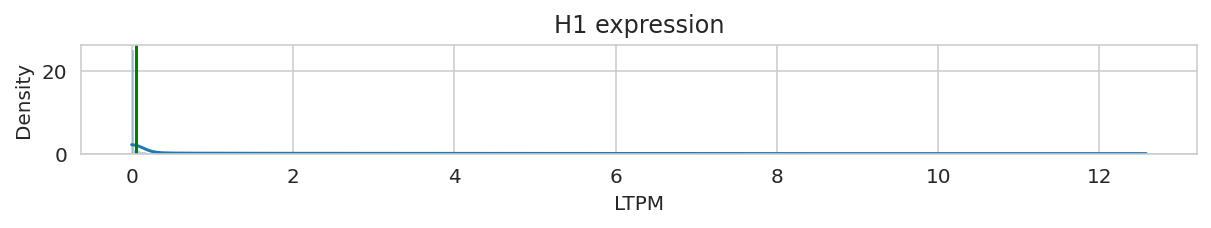

Total genes with positions 56646
Genes logTPM > 0.05 20899
Saved expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.05_tss2000.bed
HMEC rep1 HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv


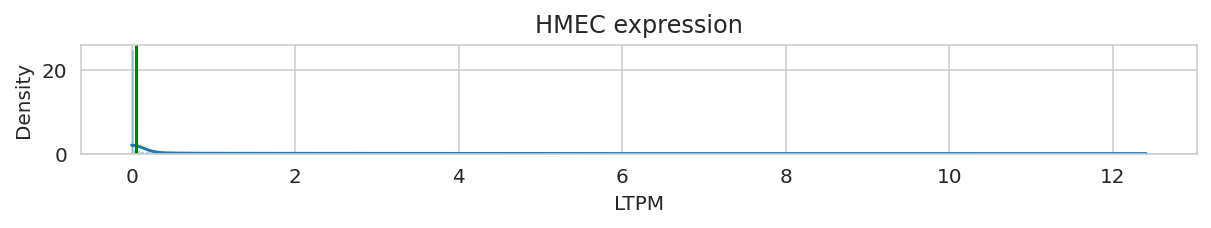

Total genes with positions 58387
Genes logTPM > 0.05 21647
Saved expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep1_RNAseq_hg38_ENCFF292FVY_tpm0.05_tss2000.bed
HMEC rep2 HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv


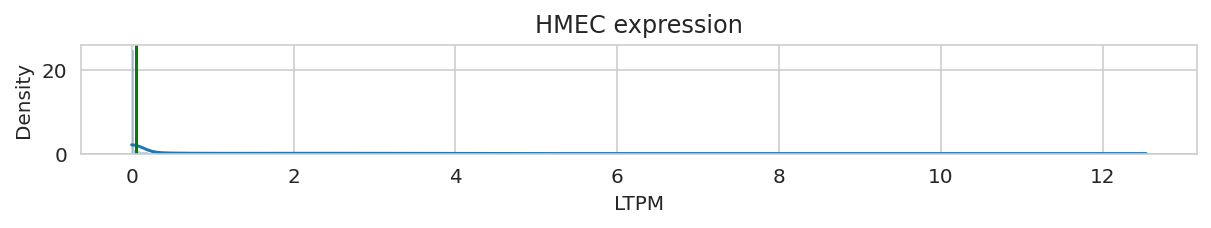

Total genes with positions 58387
Genes logTPM > 0.05 21029
Saved expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep2_RNAseq_hg38_ENCFF219EZH_tpm0.05_tss2000.bed
HSMM rep1 HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv


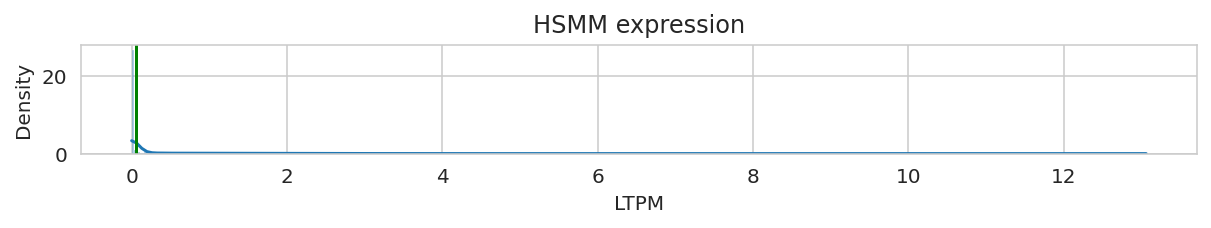

Total genes with positions 52065
Genes logTPM > 0.05 15729
Saved expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep1_RNAseq_hg38_ENCFF551YKI_tpm0.05_tss2000.bed
HSMM rep2 HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv


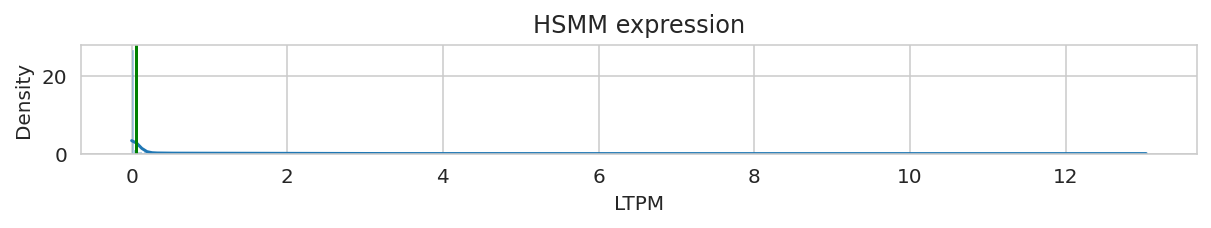

Total genes with positions 52065
Genes logTPM > 0.05 15702
Saved expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep2_RNAseq_hg38_ENCFF497BUG_tpm0.05_tss2000.bed
HepG2 rep1 HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv


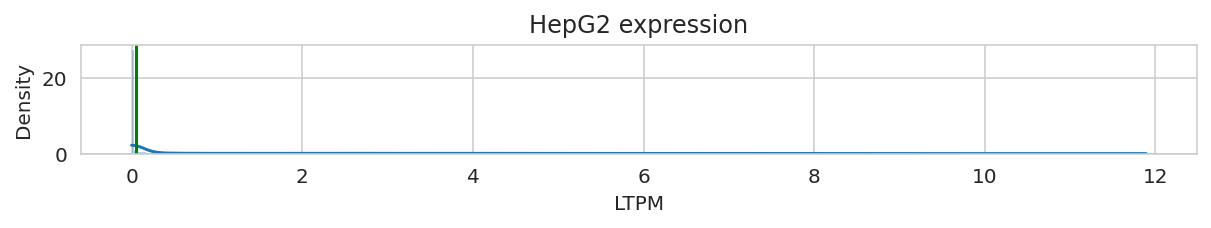

Total genes with positions 56646
Genes logTPM > 0.05 19377
Saved expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep1_RNAseq_hg38_ENCFF773JNC_tpm0.05_tss2000.bed
HepG2 rep2 HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv


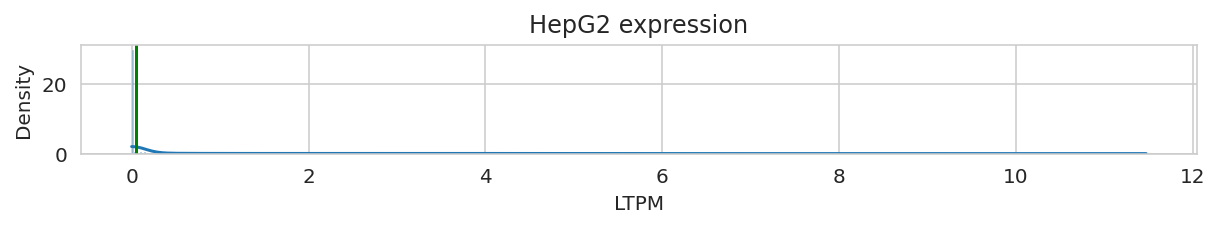

Total genes with positions 56646
Genes logTPM > 0.05 18356
Saved expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT_tpm0.05_tss2000.bed
Huvec rep1 Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv


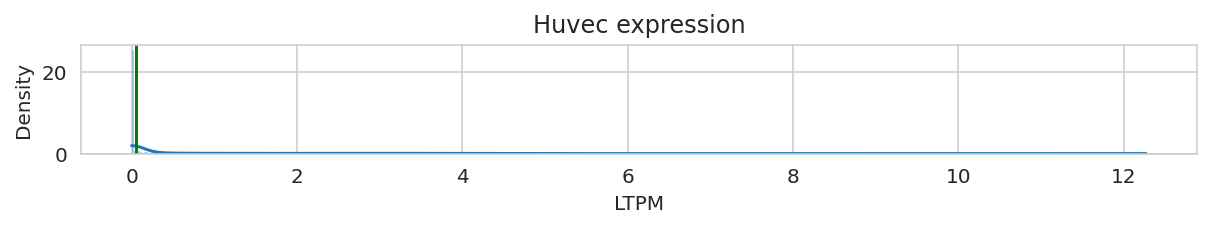

Total genes with positions 58387
Genes logTPM > 0.05 21258
Saved expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep1_RNAseq_hg38_ENCFF454MTF_tpm0.05_tss2000.bed
Huvec rep2 Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv


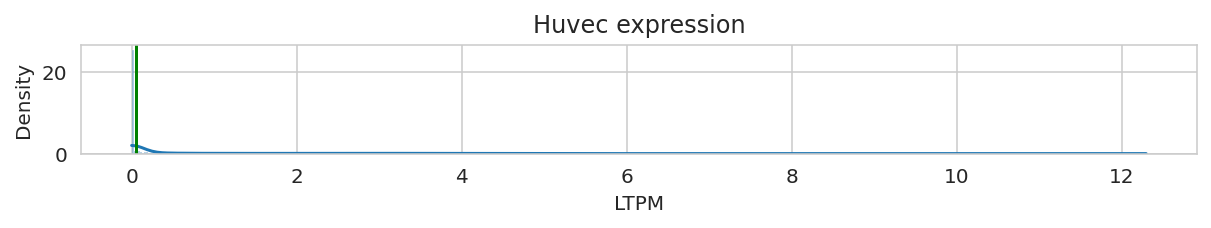

Total genes with positions 58387
Genes logTPM > 0.05 20945
Saved expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep2_RNAseq_hg38_ENCFF134FYP_tpm0.05_tss2000.bed
K562 rep1 K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv


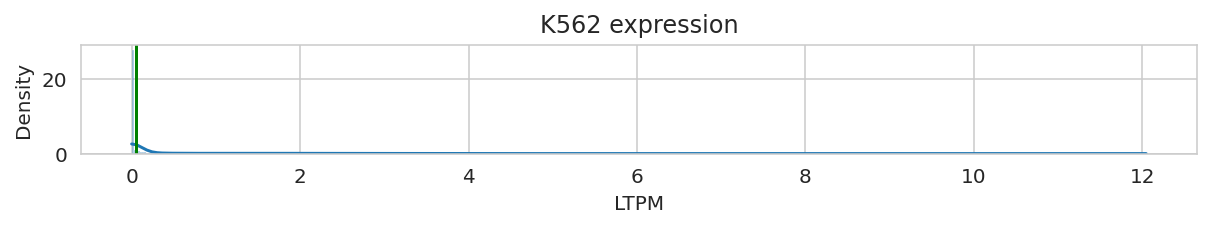

Total genes with positions 52065
Genes logTPM > 0.05 16719
Saved expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep1_RNAseq_hg38_ENCFF139IXQ_tpm0.05_tss2000.bed
K562 rep2 K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv


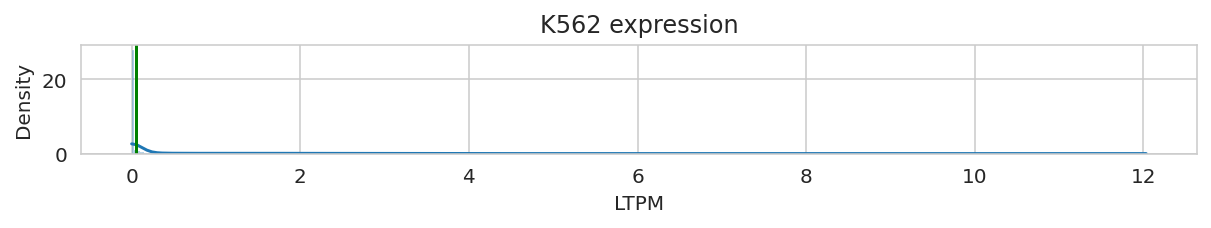

Total genes with positions 52065
Genes logTPM > 0.05 16533
Saved expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep2_RNAseq_hg38_ENCFF088RDE_tpm0.05_tss2000.bed
NHEK rep1 NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv


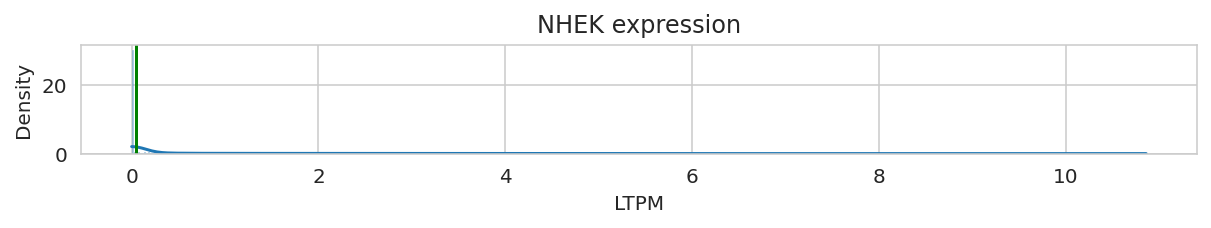

Total genes with positions 58387
Genes logTPM > 0.05 19793
Saved expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.05_tss2000.bed
NHEK rep2 NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv


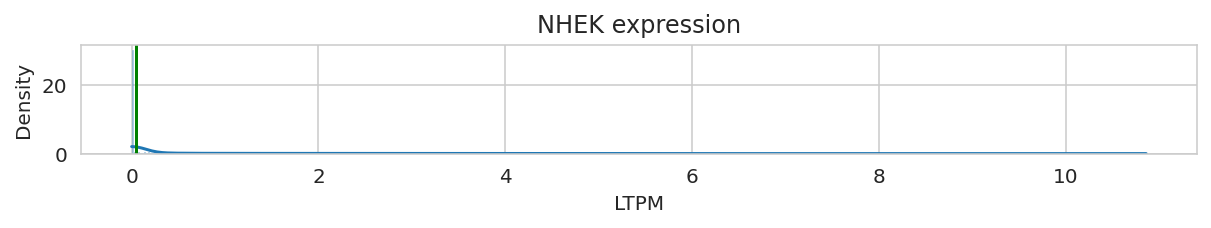

Total genes with positions 58387
Genes logTPM > 0.05 19793
Saved expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.05_tss2000.bed
NHLF rep1 NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv


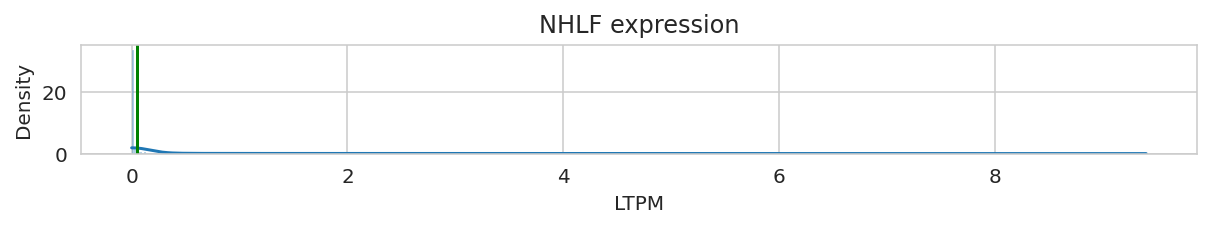

Total genes with positions 58387
Genes logTPM > 0.05 18932
Saved expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep1_RNAseq_hg38_ENCFF577DEC_tpm0.05_tss2000.bed
NHLF rep2 NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv


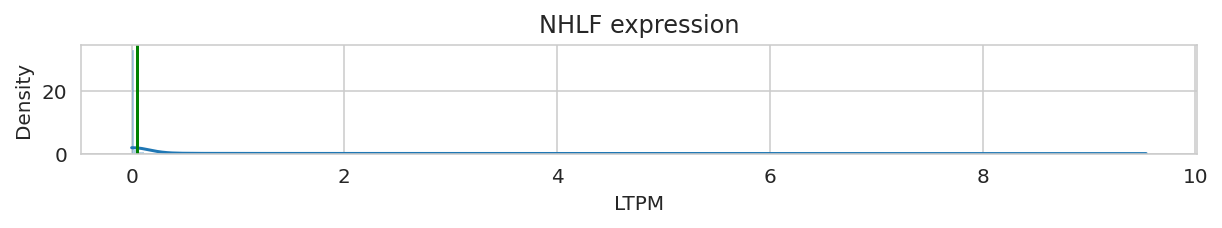

Total genes with positions 58387
Genes logTPM > 0.05 19348
Saved expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep2_RNAseq_hg38_ENCFF412KNK_tpm0.05_tss2000.bed


In [19]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

EXPRESSION_TSV = {
    ('GM12878', 'rep1') : 'GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): 'GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1') : 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2') : 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1') : 'HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2') : 'HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1') : 'HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2') : 'HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1') : 'HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2') : 'HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1') : 'Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2') : 'Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1') : 'K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2') : 'K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1') : 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2') : 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1') : 'NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2') : 'NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

EXPRESSION_TSS_BED = {}
TSS = 2000
THRESHOLD = 0.05

for (cell, rep), path in tqdm(EXPRESSION_TSV.items()):
    print(cell, rep, path)
    t = pd.read_csv(GSE26320_RNASEQ_PATH + '/' + path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    plt.figure(figsize=(10, 1))
    ax = plt.axes()
    g_results = sns.histplot(data=t, x='LTPM', ax=ax,
                             stat = 'density',
                             bins = 500, kde = True, alpha = 0.4)
    ax.axvline(x=THRESHOLD, color='green')
    ax.title.set_text(f'{cell} expression')
    plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')

    starts = [
        max(1, start - TSS) if strand == '+' else end - TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    ends = [
        start + TSS if strand == '+' else end + TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    full_df['start'] = starts
    full_df['end'] = ends
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)

    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = GSE26320_RNASEQ_PATH + '/' + path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_TSS_BED[(cell, rep)] = expr_path


## Overlap H3K4me3 with genes

In [20]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'overlap', 'peaks', 'genes', 'peaks_overlap', 'genes_overlap'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    expr_file = EXPRESSION_TSS_BED[c, r]
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        for overlap, overlap_param in [
            ('1bp overlap', ''),
            ('50% overlap', ' -f 0.5 '),
        ]:
            !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
            peaks_overlap = lines(tf)
            !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
            genes_overlap = lines(tf)
            bench_df.loc[len(bench_df)] = (c, r, tool, overlap, peaks, genes, peaks_overlap, genes_overlap)

bench_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,name,overlap,peaks,genes,peaks_overlap,genes_overlap
0,GM12878,rep1,SPAN,1bp overlap,35518,17538,9948,12707
1,GM12878,rep1,SPAN,50% overlap,35518,17538,7114,9973
2,GM12878,rep1,MACS2,1bp overlap,41149,17538,18868,11863
3,GM12878,rep1,MACS2,50% overlap,41149,17538,17898,1141
4,GM12878,rep1,SICER,1bp overlap,32672,17538,10046,12759
...,...,...,...,...,...,...,...,...
123,HepG2,rep2,MACS2,50% overlap,27438,18356,15548,1289
124,HepG2,rep2,SICER,1bp overlap,30452,18356,10940,13754
125,HepG2,rep2,SICER,50% overlap,30452,18356,9762,11237
126,HepG2,rep2,MACS2 broad,1bp overlap,19637,18356,10416,12936


In [21]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['genes_overlap'], bench_df['genes'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

In [22]:
print('Ignore outliers')
print(len(bench_df[bench_df['precision'] < 0.1]))
bench_df = bench_df[bench_df['precision'] >= 0.1]

Ignore outliers
0


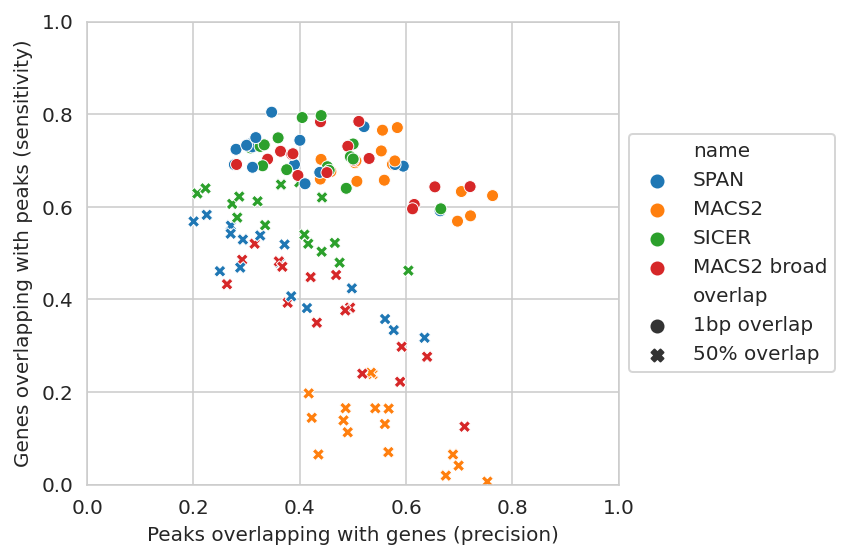

In [23]:
import seaborn as sns

plt.figure(figsize=(6, 4))
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name', style='overlap')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_results.axes.set_xlabel('Peaks overlapping with genes (precision)')
g_results.axes.set_xlim([0, 1])
g_results.axes.set_ylim([0, 1])
g_results.axes.set_ylabel('Genes overlapping with peaks (sensitivity)')
plt.tight_layout()
plt.show()

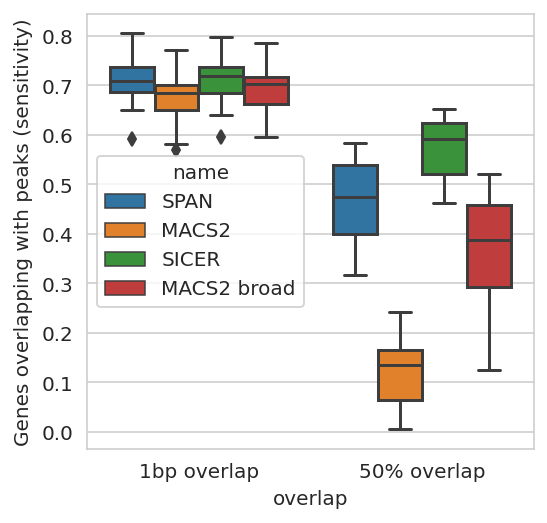

In [24]:
plt.figure(figsize=(4, 4))
g_results = sns.boxplot(data=bench_df, x='overlap', y='sensitivity', hue='name')
g_results.axes.set_ylabel('Genes overlapping with peaks (sensitivity)')
plt.show()

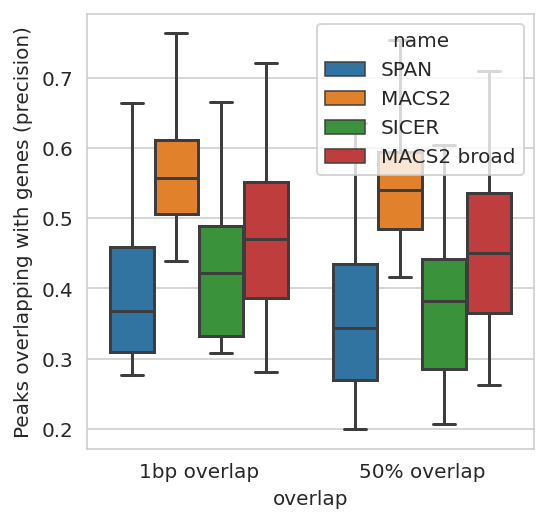

In [25]:
plt.figure(figsize=(4, 4))
g_results = sns.boxplot(data=bench_df, x='overlap', y='precision', hue='name')
g_results.axes.set_ylabel('Peaks overlapping with genes (precision)')
plt.show()

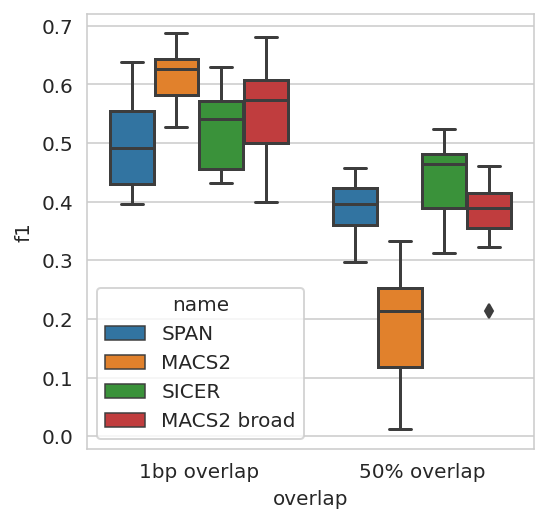

In [26]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=bench_df, x='overlap', y='f1', hue='name')
plt.show()

## Overlap diff H3K4me3 vs RNA-seq

In [27]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'overlap', 'peaks', 'peaks_overlap', 'genes', 'genes_overlap'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    print(c, r)
    expr_file = EXPRESSION_TSS_BED[(c, r)]
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = t['file'].values[0]
    genes = lines(expr_file)
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            for overlap, overlap_param in [
                ('1bp overlap', ''),
                ('50% overlap', '-f 0.5'),
            ]:
                !bedtools intersect {args} -wa -v > {tf}
                !bedtools intersect -a {tf} -b {expr_file} -wa -u {overlap_param} > {tf2}
                peaks, peaks_overlap = lines(tf), lines(tf2)
                !bedtools intersect -b {tf} -a {expr_file} -wa -u {overlap_param} > {tf2}
                genes_overlap = lines(tf2)
                diff_bench_df.loc[len(diff_bench_df)] = \
                    (c, r, name, overlap, peaks, peaks_overlap, genes, genes_overlap)

display(diff_bench_df.head())

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,name,overlap,peaks,peaks_overlap,genes,genes_overlap
0,GM12878,rep1,SPAN - MACS2,1bp overlap,16256,695,17538,728
1,GM12878,rep1,SPAN - MACS2,50% overlap,16256,608,17538,112
2,GM12878,rep1,MACS2 - SPAN,1bp overlap,4,0,17538,0
3,GM12878,rep1,MACS2 - SPAN,50% overlap,4,0,17538,0
4,GM12878,rep1,SPAN - MACS2 broad,1bp overlap,9875,319,17538,330


In [28]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap'], diff_bench_df['genes'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

In [29]:
full_bench_df = pd.concat([
    bench_df[['cell', 'replicate', 'name', 'peaks', 'overlap', 'precision', 'sensitivity']],
    diff_bench_df[['cell', 'replicate', 'name', 'peaks', 'overlap', 'precision', 'sensitivity']]]).reset_index(drop=True)
full_bench_df

,cell,replicate,name,peaks,overlap,precision,sensitivity
0,GM12878,rep1,SPAN,35518,1bp overlap,0.280083,0.724541
1,GM12878,rep1,SPAN,35518,50% overlap,0.200293,0.568651
2,GM12878,rep1,MACS2,41149,1bp overlap,0.458529,0.676417
3,GM12878,rep1,MACS2,41149,50% overlap,0.434956,0.065059
4,GM12878,rep1,SICER,32672,1bp overlap,0.307480,0.727506
...,...,...,...,...,...,...,...
315,HepG2,rep2,MACS2 broad - SPAN,0,50% overlap,0.000000,0.000000
316,HepG2,rep2,SPAN - SICER,4465,1bp overlap,0.032251,0.008063
317,HepG2,rep2,SPAN - SICER,4465,50% overlap,0.028219,0.000000
318,HepG2,rep2,SICER - SPAN,723,1bp overlap,0.048409,0.001961


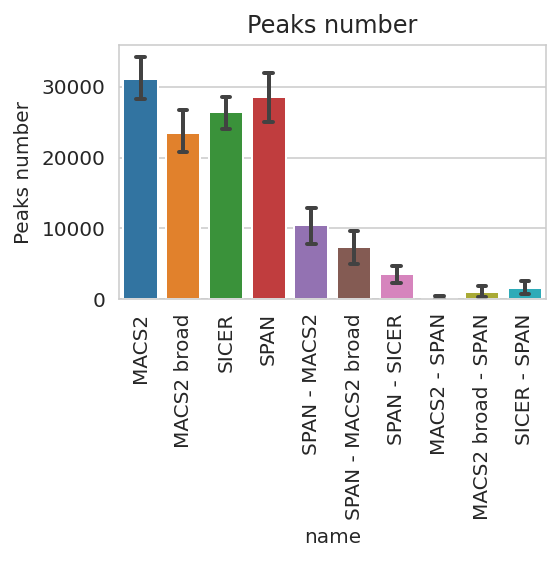

In [30]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df[full_bench_df['overlap'] == '1bp overlap'], x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

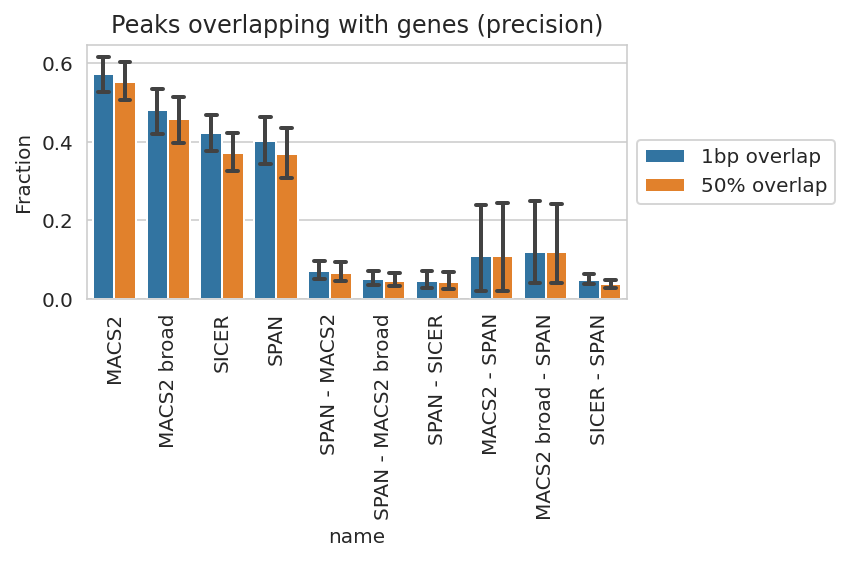

In [31]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Peaks overlapping with genes (precision)')
g_results = sns.barplot(data=full_bench_df, x='name', y='precision',
                        hue='overlap',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

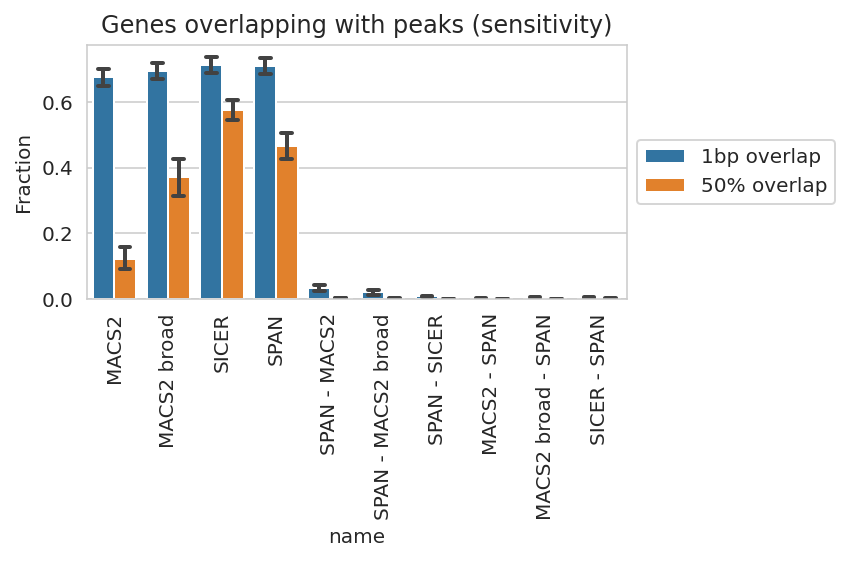

In [32]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Genes overlapping with peaks (sensitivity)')
g_results = sns.barplot(data=full_bench_df, x='name', y='sensitivity',
                        hue='overlap',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

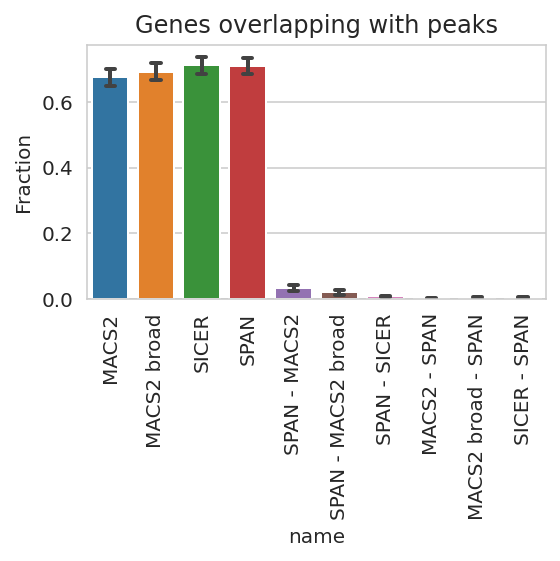

In [33]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Genes overlapping with peaks')
g_results = sns.barplot(data=full_bench_df[full_bench_df['overlap'] == '1bp overlap'], x='name', y='sensitivity',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

## Hg38 Recovered promoter fraction / Correct peak fraction

In [73]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_df = pd.DataFrame(
    columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    expr_file = EXPRESSION_TSS_BED[c, r]
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {expr_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {expr_file} -wa -u > {tf2}
            genes_overlap = lines(tf2)
            benchmark_df.loc[len(benchmark_df)] = \
                (c, r, top, genes, peaks_file, peaks, peaks_overlap, genes_overlap, tool)

benchmark_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool
0,GM12878,rep1,1000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,1000,886,1438,SPAN
1,GM12878,rep1,2000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,2000,1786,2815,SPAN
2,GM12878,rep1,3000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,3000,2662,4082,SPAN
3,GM12878,rep1,4000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,4000,3541,5278,SPAN
4,GM12878,rep1,5000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,5000,4388,6408,SPAN
...,...,...,...,...,...,...,...,...,...
955,HepG2,rep2,11000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,11000,8578,11111,MACS2 broad
956,HepG2,rep2,12000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,12000,8996,11579,MACS2 broad
957,HepG2,rep2,13000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,13000,9322,11918,MACS2 broad
958,HepG2,rep2,14000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,14000,9556,12163,MACS2 broad


In [74]:
benchmark_df['p'] = (benchmark_df['pg'] + benchmark_df['gp']) / 2
benchmark_df['precision'] = [d(x, y) for x, y in zip(benchmark_df['pg'], benchmark_df['peaks'])]
benchmark_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_df['gp'], benchmark_df['genes'])]
benchmark_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_df['sensitivity'], benchmark_df['precision'])]
benchmark_df

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
0,GM12878,rep1,1000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,1000,886,1438,SPAN,1162.0,0.886000,0.081993,0.150096
1,GM12878,rep1,2000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,2000,1786,2815,SPAN,2300.5,0.893000,0.160509,0.272108
2,GM12878,rep1,3000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,3000,2662,4082,SPAN,3372.0,0.887333,0.232752,0.368773
3,GM12878,rep1,4000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,4000,3541,5278,SPAN,4409.5,0.885250,0.300947,0.449188
4,GM12878,rep1,5000.0,17538,/home/jetbrains/data/2023_GSE26320/span/GSM646...,5000,4388,6408,SPAN,5398.0,0.877600,0.365378,0.515948
...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,HepG2,rep2,11000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,11000,8578,11111,MACS2 broad,9844.5,0.779818,0.605306,0.681569
956,HepG2,rep2,12000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,12000,8996,11579,MACS2 broad,10287.5,0.749667,0.630802,0.685117
957,HepG2,rep2,13000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,13000,9322,11918,MACS2 broad,10620.0,0.717077,0.649270,0.681491
958,HepG2,rep2,14000.0,18356,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,14000,9556,12163,MACS2 broad,10859.5,0.682571,0.662617,0.672446


In [75]:
import plotly.graph_objects as go

def plot_top(benchmark_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_df[(benchmark_df['cell'] == c) & (benchmark_df['replicate'] == r) &
                           (benchmark_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=TOOLS_PALETTE[t],
            opacity=0.3,
        ))
        tools_legend_shown.add(t)

    # for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
    #     dft = benchmark_df[(benchmark_df['cell'] == c) & (benchmark_df['replicate'] == r) &
    #                        (benchmark_df['tool'] == t) &
    #                        (benchmark_df['top'] != 1000)]
    #     if len(dft) == 0:
    #         continue
    #     fig.add_trace(
    #         go.Scatter(
    #             mode='markers',
    #             x=dft["precision"], y=dft["sensitivity"],
    #             name=t,
    #             marker=dict(color='white', size=3, line=dict(width=1)),
    #             showlegend=False,
    #             hovertext=dft['top'].astype(str) + ' ' + t,
    #             opacity=0.3,
    #         )
    #     )
    #
    #
    # marker = 'square' if overlap == '1bp overlap' else  'circle' if overlap == '50% overlap' else 'diamond'
    # for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
    #     dft = benchmark_df[(benchmark_df['cell'] == c) & (benchmark_df['replicate'] == r) &
    #                        (benchmark_df['tool'] == t) &
    #                        (benchmark_df['top'] == 1000)]
    #     if len(dft) == 0:
    #         continue
    #     fig.add_trace(
    #         go.Scatter(
    #             mode='markers',
    #             x=dft["precision"], y=dft["sensitivity"],
    #             name=t,
    #             marker=dict(color='white', size=5, line=dict(width=1)),
    #             showlegend=False,
    #             hovertext=dft['top'].astype(str) + ' ' + t
    #         )
    #     )

    # fig.update_xaxes(range=[-0.1, 1.1], title='Peaks overlapping active genes (precision)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Active genes overlapping peaks (sensitivity)')
    fig.update_xaxes(title='Correct promoter fraction (sensitivity)')
    fig.update_yaxes(title='Recovered promoter fraction (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)
    fig.show()


In [76]:
plot_top(benchmark_df[(benchmark_df['cell'] == 'GM12878') & (benchmark_df['replicate'] == 'rep1')])

In [77]:
plot_top(benchmark_df)

# hg19 Recovered promoter fraction / Correct peak fraction

In [38]:
df = pd.read_csv(os.path.expanduser('~/data/2022_GSE26320_GM12878_chipseq/k4me3_report.tsv'), sep='\t',
                 names=['n', 'file', 'peaks', 'tss_peaks', 'cp', 'rp'])
df['cpf'] = df['cp'] / df['peaks']
df['rpf'] = df['rp'] / df['tss_peaks']
df

,n,file,peaks,tss_peaks,cp,rp,cpf,rpf
0,1000,GSM646327_GM12878_H3K4me3_rep2_q0.05_peaks.nar...,1000,13633,889,1177,0.889000,0.086335
1,1000,GSM646327_GM12878_H3K4me3_rep2_broad0.1_peaks....,1000,13633,868,1134,0.868000,0.083181
2,1000,GSM646327_GM12878_H3K4me3_rep2-W200-G600-islan...,1000,13633,666,963,0.666000,0.070637
3,1000,GSM646327_GM12878_H3K4me3_rep2_50_0.05_3.peak,1000,13633,866,1303,0.866000,0.095577
4,2000,GSM646327_GM12878_H3K4me3_rep2_q0.05_peaks.nar...,2000,13633,1753,2245,0.876500,0.164674
5,2000,GSM646327_GM12878_H3K4me3_rep2_broad0.1_peaks....,2000,13633,1730,2256,0.865000,0.165481
6,2000,GSM646327_GM12878_H3K4me3_rep2-W200-G600-islan...,2000,13633,1363,1929,0.681500,0.141495
7,2000,GSM646327_GM12878_H3K4me3_rep2_50_0.05_3.peak,2000,13633,1763,2556,0.881500,0.187486
8,3000,GSM646327_GM12878_H3K4me3_rep2_q0.05_peaks.nar...,3000,13633,2600,3255,0.866667,0.238759
9,3000,GSM646327_GM12878_H3K4me3_rep2_broad0.1_peaks....,3000,13633,2559,3327,0.853000,0.244040


In [54]:
def detect_tool(file):
    if '.narrowPeak' in file:
        return 'MACS2'
    elif '.broadPeak' in file:
        return 'MACS2 broad'
    elif '.peak' in file:
        return 'SPAN'
    else:
        return 'SICER'


df['tool'] = [detect_tool(f) for f in df['file']]
df['dir'] = ['macs2' if 'MACS2' in tool else 'sicer' if tool == 'SICER' else 'SPAN' for tool in df['tool']]

In [46]:
# import plotly.express as px
#
# fig = px.line(df, x="rpf", y="cpf", color="tool", hover_name="n")
# fig.update_xaxes(range=[0, 1], row=1, col=1, title='recovered promoter fraction')
# fig.update_yaxes(range=[0, 1], row=1, col=1, title='correct peak fraction')
# fig.show()

In [55]:
import plotly.graph_objects as go

fig = go.Figure()
for t in set(df['tool']):
    dft = df[df['tool'] == t]
    fig.add_trace(go.Scatter(
        x=dft["rpf"], y=dft["cpf"], mode='lines+markers', name=t, hovertext=dft['n']))
fig.update_xaxes(range=[0, 0.8], title='Recovered Promoter Fraction')
fig.update_yaxes(range=[0, 1], title='Correct Peak Fraction')
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()

In [56]:
import plotly.express as px

fig = px.line(df, x="rpf", y="cpf", color="tool")
fig.update_xaxes(title='Recovered Promoter Fraction')
fig.update_yaxes(title='Correct Peak Fraction')
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()
# plt.savefig(os.path.expanduser('~/data/2022_GSE26320_k4me3') + '/sens.pdf')

In [57]:
df['precision'] = df['cpf']
df['sensitivity'] = df['rpf']
df['f1'] = [2 / (1 / s + 1 / p) for s, p in zip(df['sensitivity'], df['precision'])]

In [58]:
import plotly.express as px

fig = px.line(df, x="peaks", y="sensitivity", color="tool")
fig.update_xaxes(title='Peaks')
fig.update_yaxes(title='Sensitivity (Recall)')
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()
# plt.savefig(os.path.expanduser('~/data/2022_GSE26320_k4me3') + '/sens.pdf')

In [59]:
import plotly.express as px

fig = px.line(df, x="peaks", y="precision", color="tool")
fig.update_xaxes(title='Peaks')
fig.update_yaxes(title='Precision')
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()
# plt.savefig(os.path.expanduser('~/data/2022_GSE26320_k4me3') + '/sens.pdf')

In [60]:
import plotly.express as px

fig = px.line(df, x="peaks", y="f1", color="tool")
fig.update_xaxes(title='Peaks')
fig.update_yaxes(title='F1')
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()
# plt.savefig(os.path.expanduser('~/data/2022_GSE26320_k4me3') + '/sens.pdf')